# Simulating and Analyzing the Dynamics of a Limit Order Book under Agent-Based Models and Poisson Order Flow

## Introduction

The goal of this project is to use agent-based modeling and Poisson order flow processes to simulate and study the dynamics of a limit order book (LOB).  A key element of contemporary computerized financial markets is the limit order book, which is a compilation of all buy and sell orders for a specific securities at different price points.  Researchers, policymakers, and market participants must all comprehend its dynamics.

## Goals and Relevance:

- Model a realistic limit order book with multiple price levels.

- Implement agent-based models for different trader behaviors.

- Simulate order flow using Poisson processes.

- Analyze key metrics like spread, depth, and price impact.

- Visualize the evolution of the order book over time.

- Study market stability under different conditions.

The project is relevant for:

- Algorithmic trading strategy development.

- Market microstructure research.

- Exchange design and regulation.

- Understanding price formation mechanisms.

## 1. Limit Order Book Structure

We will begin by implementing the basic structure of a limit order book that can handle limit orders, market orders, and cancellations.

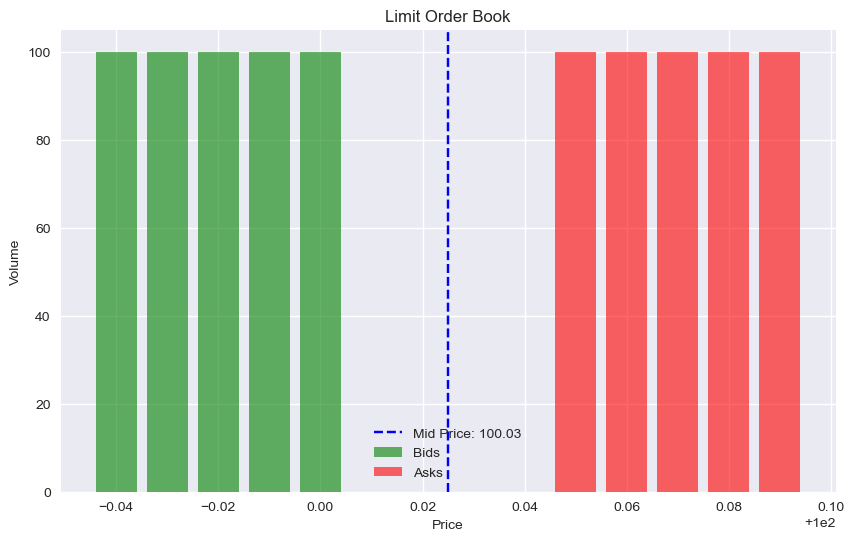

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from typing import List, Dict, Tuple
import random
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import plotly.graph_objects as go
from scipy.stats import poisson

class LimitOrderBook:
    def __init__(self, tick_size=0.01, num_levels=10):
        self.tick_size = tick_size
        self.num_levels = num_levels
        self.bids = OrderedDict()  
        self.asks = OrderedDict()
        self.order_id_counter = 0
        self.mid_price_history = []
        self.spread_history = []
        self.time = 0
        
    def add_order(self, is_buy: bool, price: float, volume: float, order_type: str = 'limit') -> int:
        """Add an order to the book"""
        self.order_id_counter += 1
        order_id = self.order_id_counter
        
        if order_type == 'market':
            # Market orders execute immediately against best available price
            self.execute_market_order(is_buy, volume)
            return order_id
        
        price = round(price / self.tick_size) * self.tick_size  
        
        if is_buy:
            book = self.bids
        else:
            book = self.asks
            
        if price not in book:
            book[price] = [0, {}]
        
        book[price][0] += volume
        book[price][1][order_id] = volume
        
        # Re-sort the book
        if is_buy:
            self.bids = OrderedDict(sorted(self.bids.items(), key=lambda x: -x[0]))
        else:
            self.asks = OrderedDict(sorted(self.asks.items(), key=lambda x: x[0]))
            
        return order_id
    
    def cancel_order(self, order_id: int) -> bool:
        """Cancel an existing order"""
        # Search bids
        for price, (total_volume, orders) in self.bids.items():
            if order_id in orders:
                self.bids[price][0] -= orders[order_id]
                del self.bids[price][1][order_id]
                if self.bids[price][0] == 0:
                    del self.bids[price]
                return True
        
        # Search asks
        for price, (total_volume, orders) in self.asks.items():
            if order_id in orders:
                self.asks[price][0] -= orders[order_id]
                del self.asks[price][1][order_id]
                if self.asks[price][0] == 0:
                    del self.asks[price]
                return True
        
        return False
    
    def execute_market_order(self, is_buy: bool, volume: float) -> float:
        """Execute a market order"""
        executed_volume = 0
        remaining_volume = volume
        
        if is_buy:
            # Buying at ask prices
            while remaining_volume > 0 and self.asks:
                best_ask = next(iter(self.asks))
                available_volume = self.asks[best_ask][0]
                
                if available_volume <= remaining_volume:
                    executed_volume += available_volume
                    remaining_volume -= available_volume
                    del self.asks[best_ask]
                else:
                    executed_volume += remaining_volume
                    self.asks[best_ask][0] -= remaining_volume
                    # Remove individual orders as they get filled
                    for order_id, vol in list(self.asks[best_ask][1].items()):
                        if vol <= remaining_volume:
                            remaining_volume -= vol
                            del self.asks[best_ask][1][order_id]
                        else:
                            self.asks[best_ask][1][order_id] -= remaining_volume
                            remaining_volume = 0
                            break
                    remaining_volume = 0
        else:
            # Selling at bid prices
            while remaining_volume > 0 and self.bids:
                best_bid = next(iter(self.bids))
                available_volume = self.bids[best_bid][0]
                
                if available_volume <= remaining_volume:
                    executed_volume += available_volume
                    remaining_volume -= available_volume
                    del self.bids[best_bid]
                else:
                    executed_volume += remaining_volume
                    self.bids[best_bid][0] -= remaining_volume
                    # Remove individual orders as they get filled
                    for order_id, vol in list(self.bids[best_bid][1].items()):
                        if vol <= remaining_volume:
                            remaining_volume -= vol
                            del self.bids[best_bid][1][order_id]
                        else:
                            self.bids[best_bid][1][order_id] -= remaining_volume
                            remaining_volume = 0
                            break
                    remaining_volume = 0
        
        return executed_volume
    
    def get_best_bid(self) -> float:
        """Get best bid price"""
        return next(iter(self.bids)) if self.bids else None
    
    def get_best_ask(self) -> float:
        """Get best ask price"""
        return next(iter(self.asks)) if self.asks else None
    
    def get_mid_price(self) -> float:
        """Calculate mid price"""
        best_bid = self.get_best_bid()
        best_ask = self.get_best_ask()
        if best_bid and best_ask:
            return (best_bid + best_ask) / 2
        return None
    
    def get_spread(self) -> float:
        """Calculate bid-ask spread"""
        best_bid = self.get_best_bid()
        best_ask = self.get_best_ask()
        if best_bid and best_ask:
            return best_ask - best_bid
        return None
    
    def get_order_book_snapshot(self, levels=None) -> Dict:
        """Get a snapshot of the order book"""
        levels = levels or self.num_levels
        bid_prices = list(self.bids.keys())[:levels]
        ask_prices = list(self.asks.keys())[:levels]
        
        snapshot = {
            'bids': {price: self.bids[price][0] for price in bid_prices},
            'asks': {price: self.asks[price][0] for price in ask_prices}
        }
        return snapshot
    
    def step(self, time_increment=1):
        """Advance time in the simulation"""
        self.time += time_increment
        mid_price = self.get_mid_price()
        if mid_price is not None:
            self.mid_price_history.append((self.time, mid_price))
        spread = self.get_spread()
        if spread is not None:
            self.spread_history.append((self.time, spread))
    
    def visualize_order_book(self):
        """Visualize the current state of the order book"""
        snapshot = self.get_order_book_snapshot()
        
        bid_prices = list(snapshot['bids'].keys())
        bid_volumes = list(snapshot['bids'].values())
        ask_prices = list(snapshot['asks'].keys())
        ask_volumes = list(snapshot['asks'].values())
        
        plt.figure(figsize=(10, 6))
        
        # Plot bids
        if bid_prices:
            plt.bar(bid_prices, bid_volumes, width=self.tick_size*0.8, 
                    color='green', alpha=0.6, label='Bids')
        
        # Plot asks
        if ask_prices:
            plt.bar(ask_prices, ask_volumes, width=self.tick_size*0.8, 
                    color='red', alpha=0.6, label='Asks')
        
        # Plot mid price if available
        mid_price = self.get_mid_price()
        if mid_price:
            plt.axvline(x=mid_price, color='blue', linestyle='--', 
                        label=f'Mid Price: {mid_price:.2f}')
        
        plt.xlabel('Price')
        plt.ylabel('Volume')
        plt.title('Limit Order Book')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_price_history(self):
        """Plot the historical mid prices"""
        if not self.mid_price_history:
            print("No price history available")
            return
        
        times, prices = zip(*self.mid_price_history)
        plt.figure(figsize=(10, 5))
        plt.plot(times, prices, label='Mid Price')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.title('Mid Price History')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    def plot_spread_history(self):
        """Plot the historical spreads"""
        if not self.spread_history:
            print("No spread history available")
            return
        
        times, spreads = zip(*self.spread_history)
        plt.figure(figsize=(10, 5))
        plt.plot(times, spreads, label='Spread', color='orange')
        plt.xlabel('Time')
        plt.ylabel('Spread')
        plt.title('Bid-Ask Spread History')
        plt.grid(True)
        plt.legend()
        plt.show()

# Test the LimitOrderBook class
lob = LimitOrderBook(tick_size=0.01, num_levels=5)

# Add some initial liquidity
for i in range(5):
    lob.add_order(True, 100.00 - i*0.01, 100)  # Bids
    lob.add_order(False, 100.05 + i*0.01, 100)  # Asks

lob.visualize_order_book()

## 2. Agent-Based Modeling

Now we will implement different types of trading agents that interact with the limit order book.


Step 0:


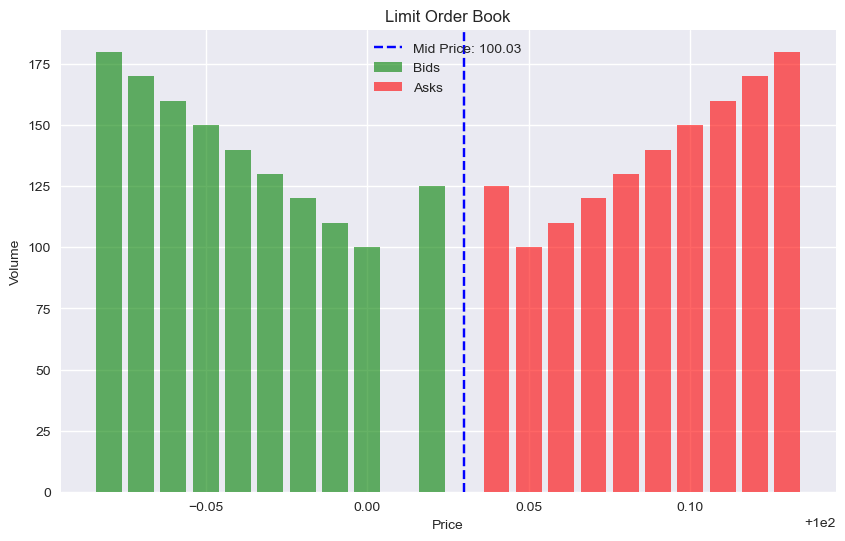


Step 10:


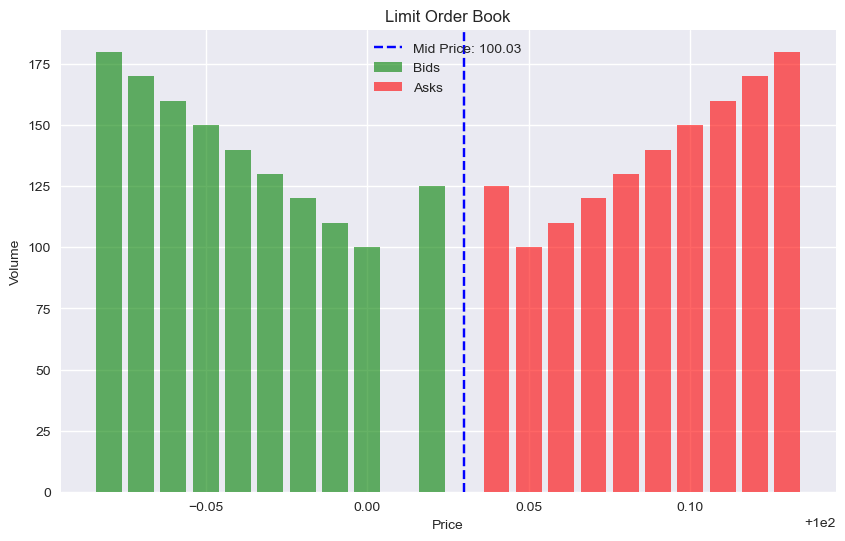


Step 20:


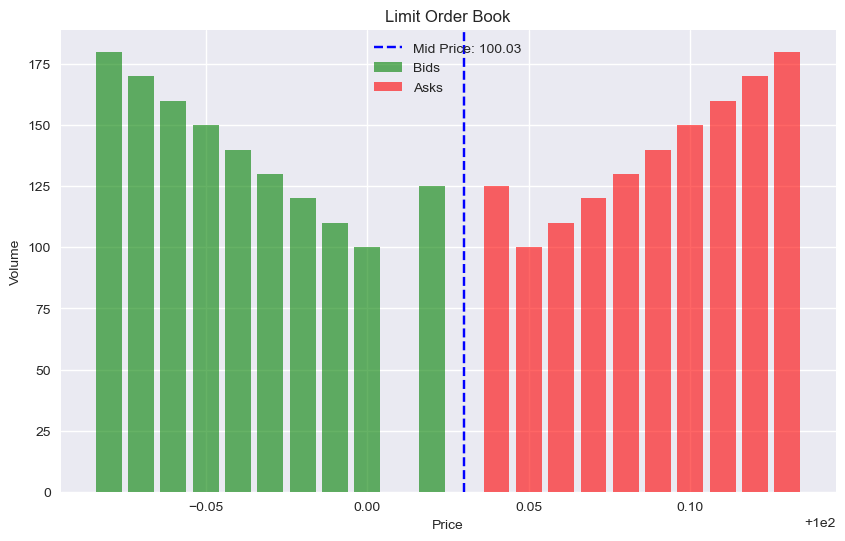


Step 30:


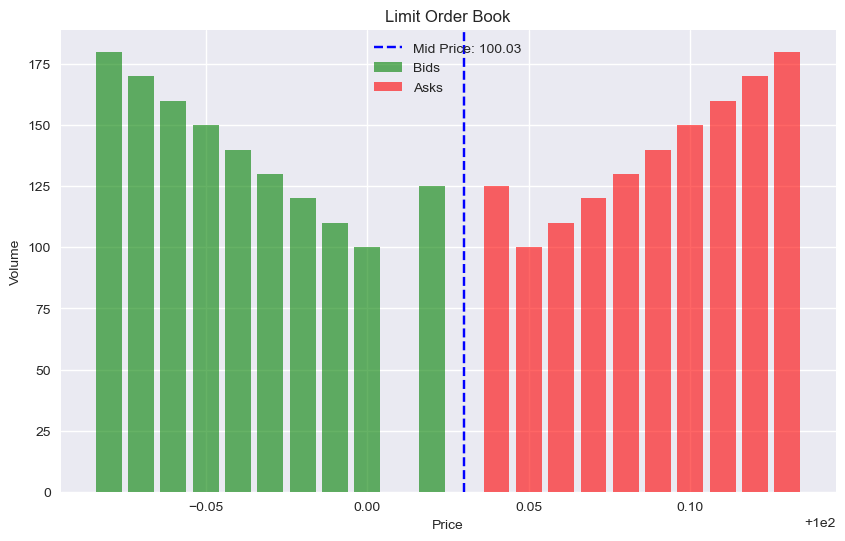


Step 40:


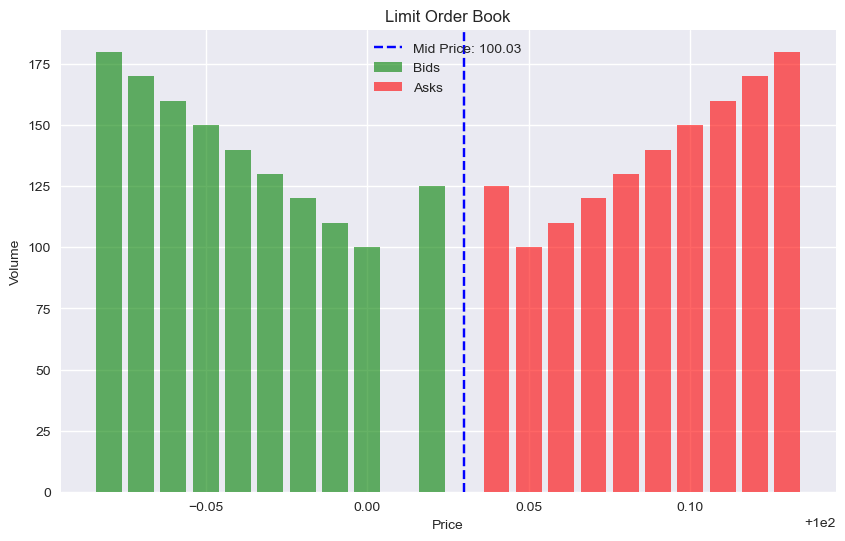

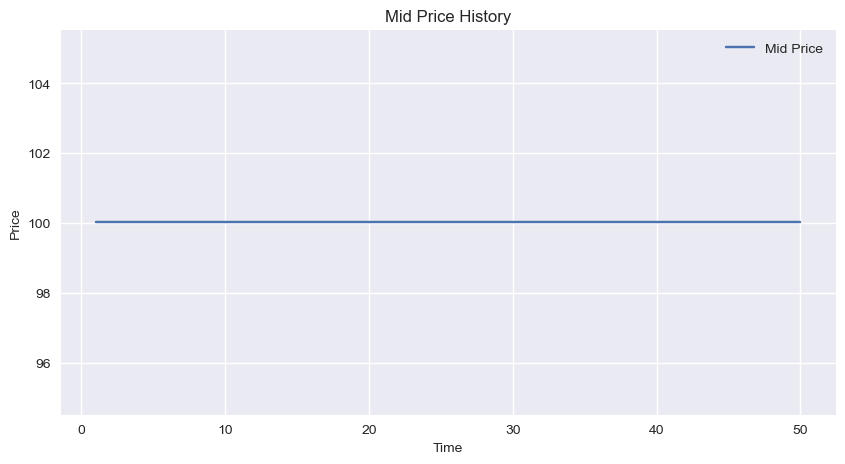

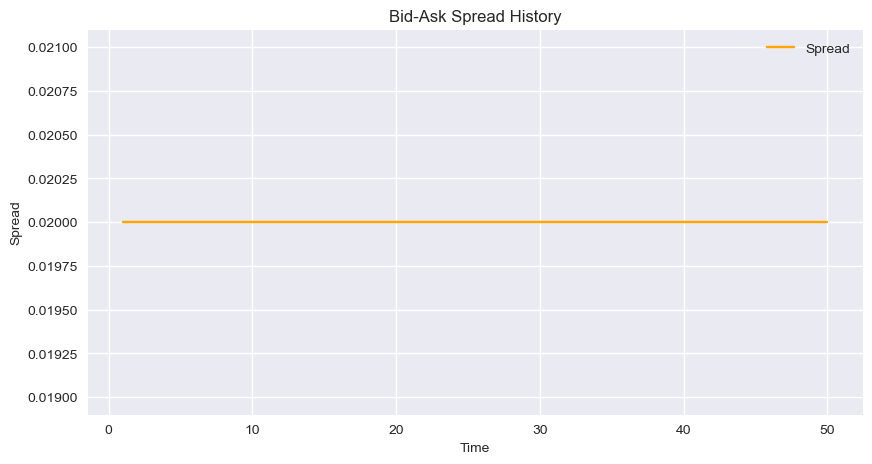

In [33]:
class TradingAgent:
    """Base class for trading agents"""
    def __init__(self, agent_id: int, lob: LimitOrderBook):
        self.agent_id = agent_id
        self.lob = lob
        self.active_orders = set()  
    
    def act(self, current_time: float):
        """Perform trading action - to be implemented by subclasses"""
        raise NotImplementedError
    
    def cancel_all_orders(self):
        """Cancel all active orders from this agent"""
        for order_id in list(self.active_orders):
            if self.lob.cancel_order(order_id):
                self.active_orders.remove(order_id)
    
    def __str__(self):
        return f"{self.__class__.__name__}_{self.agent_id}"


class MarketMaker(TradingAgent):
    """Market making agent that provides liquidity"""
    def __init__(self, agent_id: int, lob: LimitOrderBook, 
                 inventory_target=0, max_inventory=1000, 
                 spread_width=0.02, order_size=100):
        super().__init__(agent_id, lob)
        self.inventory = 0
        self.inventory_target = inventory_target
        self.max_inventory = max_inventory
        self.spread_width = spread_width
        self.order_size = order_size
    
    def act(self, current_time: float):
        # Cancel all existing orders
        self.cancel_all_orders()
        
        # Get current best prices
        best_bid = self.lob.get_best_bid()
        best_ask = self.lob.get_best_ask()
        
        # Calculate our desired prices based on inventory
        inventory_imbalance = self.inventory / self.max_inventory
        spread_adjustment = self.spread_width * (1 + abs(inventory_imbalance))
        
        if best_bid and best_ask:
            mid_price = (best_bid + best_ask) / 2
        else:
            # If no orders in book, use some default price
            mid_price = 100.00
        
        # Calculate bid and ask prices
        our_bid = mid_price - spread_adjustment/2
        our_ask = mid_price + spread_adjustment/2
        
        # Adjust based on inventory
        if self.inventory > 0:
            # Want to sell more, so lower prices
            our_bid -= inventory_imbalance * 0.01
            our_ask -= inventory_imbalance * 0.01
        elif self.inventory < 0:
            # Want to buy more, so raise prices
            our_bid -= inventory_imbalance * 0.01
            our_ask -= inventory_imbalance * 0.01
        
        # Place new orders
        if abs(self.inventory) < self.max_inventory:
            bid_id = self.lob.add_order(True, our_bid, self.order_size)
            ask_id = self.lob.add_order(False, our_ask, self.order_size)
            self.active_orders.update([bid_id, ask_id])


class NoiseTrader(TradingAgent):
    """Random trader that submits market orders"""
    def __init__(self, agent_id: int, lob: LimitOrderBook, 
                 order_prob=0.1, max_volume=100):
        super().__init__(agent_id, lob)
        self.order_prob = order_prob
        self.max_volume = max_volume
    
    def act(self, current_time: float):
        if random.random() < self.order_prob:
            is_buy = random.choice([True, False])
            volume = random.randint(1, self.max_volume)
            self.lob.execute_market_order(is_buy, volume)


class MomentumTrader(TradingAgent):
    """Trader that follows price trends"""
    def __init__(self, agent_id: int, lob: LimitOrderBook, 
                 lookback=5, threshold=0.01, order_size=50):
        super().__init__(agent_id, lob)
        self.lookback = lookback
        self.threshold = threshold
        self.order_size = order_size
        self.price_history = []
    
    def act(self, current_time: float):
        mid_price = self.lob.get_mid_price()
        if mid_price is None:
            return
            
        self.price_history.append(mid_price)
        if len(self.price_history) > self.lookback:
            self.price_history.pop(0)
        
        if len(self.price_history) == self.lookback:
            price_change = self.price_history[-1] - self.price_history[0]
            if price_change > self.threshold:
                # Price going up - buy
                self.lob.execute_market_order(True, self.order_size)
            elif price_change < -self.threshold:
                # Price going down - sell
                self.lob.execute_market_order(False, self.order_size)


class MeanReversionTrader(TradingAgent):
    """Trader that bets on price returning to mean"""
    def __init__(self, agent_id: int, lob: LimitOrderBook, 
                 lookback=20, threshold=0.02, order_size=50):
        super().__init__(agent_id, lob)
        self.lookback = lookback
        self.threshold = threshold
        self.order_size = order_size
        self.price_history = []
    
    def act(self, current_time: float):
        mid_price = self.lob.get_mid_price()
        if mid_price is None:
            return
            
        self.price_history.append(mid_price)
        if len(self.price_history) > self.lookback:
            self.price_history.pop(0)
        
        if len(self.price_history) == self.lookback:
            mean_price = sum(self.price_history) / len(self.price_history)
            deviation = mid_price - mean_price
            
            if deviation > self.threshold:
                # Price above mean - sell
                self.lob.execute_market_order(False, self.order_size)
            elif deviation < -self.threshold:
                # Price below mean - buy
                self.lob.execute_market_order(True, self.order_size)


# Create a simulation with multiple agents
def run_simulation(num_steps=100, visualize_every=10):
    lob = LimitOrderBook(tick_size=0.01, num_levels=10)
    
    # Add initial liquidity
    for i in range(10):
        lob.add_order(True, 100.00 - i*0.01, 100 + i*10)  # Bids
        lob.add_order(False, 100.05 + i*0.01, 100 + i*10)  # Asks
    
    # Create agents
    agents = [
        MarketMaker(1, lob, order_size=50),
        MarketMaker(2, lob, order_size=75),
        NoiseTrader(3, lob),
        MomentumTrader(4, lob),
        MeanReversionTrader(5, lob)
    ]
    
    # Run simulation
    for step in range(num_steps):
        # Agents act
        for agent in agents:
            agent.act(step)
        
        # Update time in LOB
        lob.step()
        
        # Visualize periodically
        if step % visualize_every == 0:
            print(f"\nStep {step}:")
            lob.visualize_order_book()
    
    # Plot results
    lob.plot_price_history()
    lob.plot_spread_history()

# Run the simulation
run_simulation(num_steps=50, visualize_every=10)

## 3. Poisson Order Flow Simulation

We will now implement a more sophisticated order flow simulation using Poisson processes.


Time 1.0:


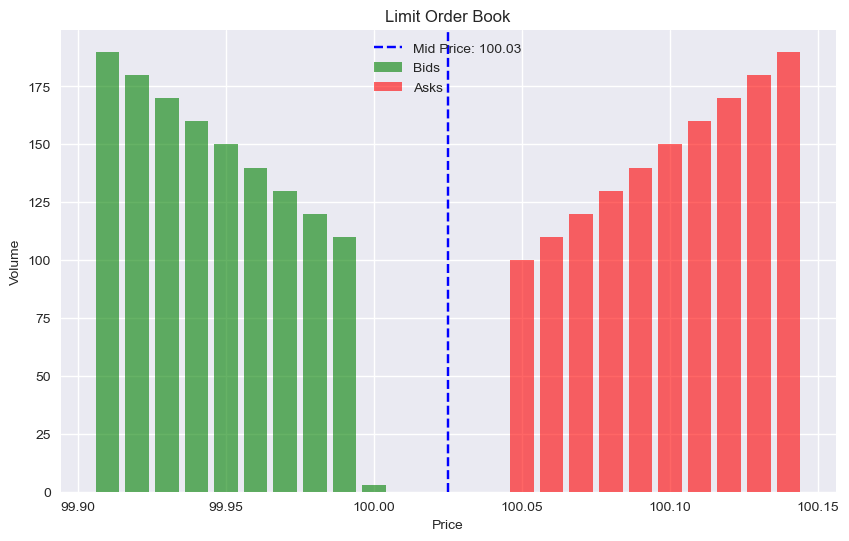


Time 11.0:


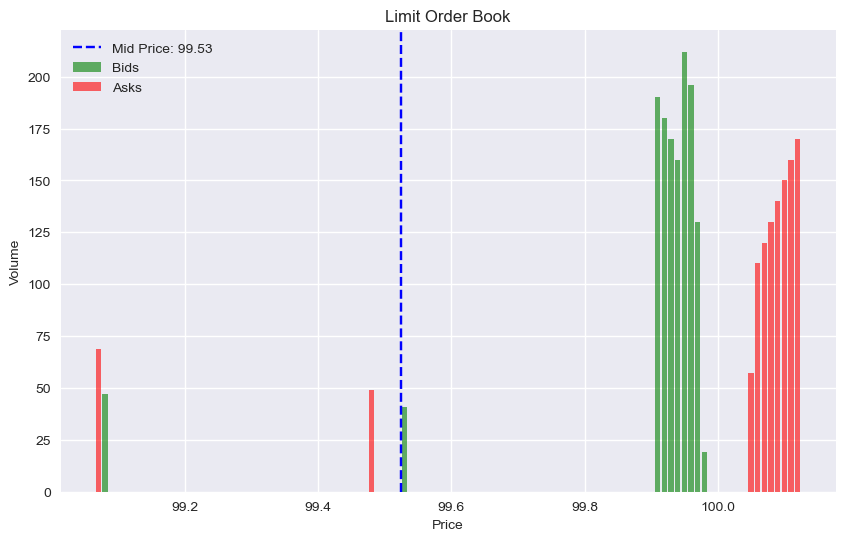


Time 21.0:


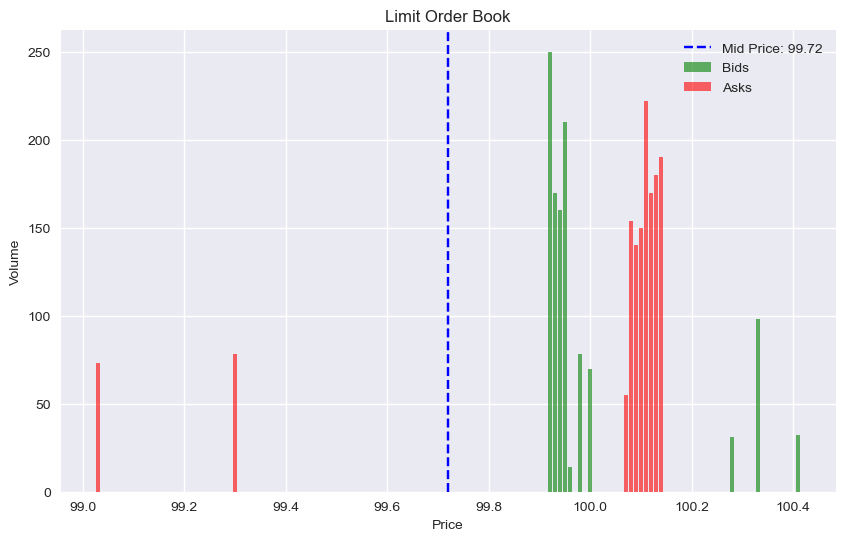


Time 31.0:


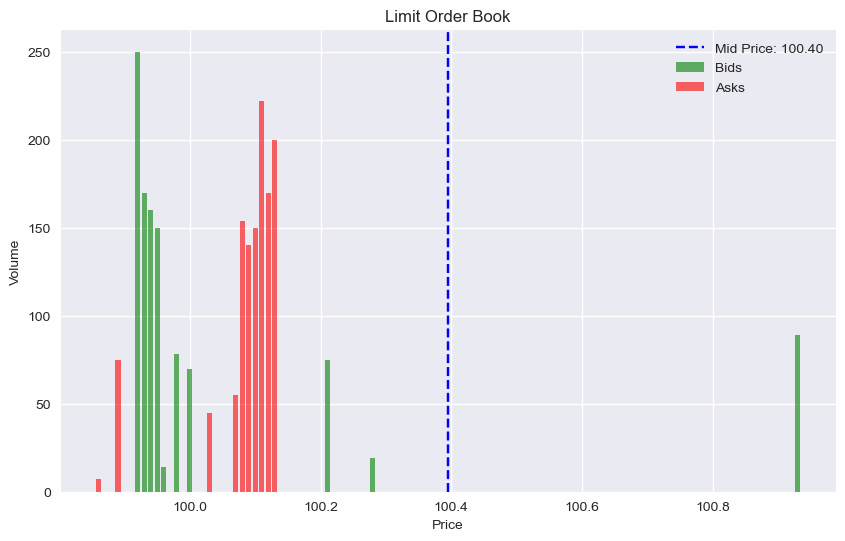


Time 41.0:


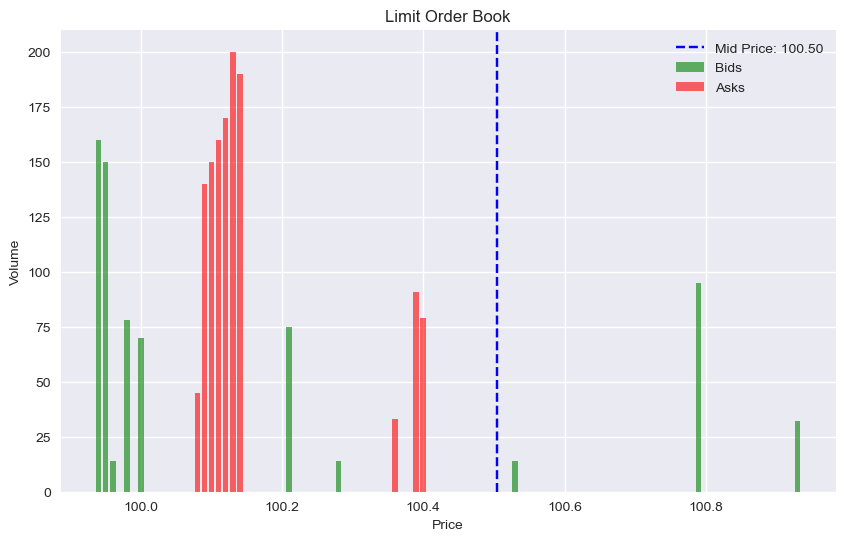

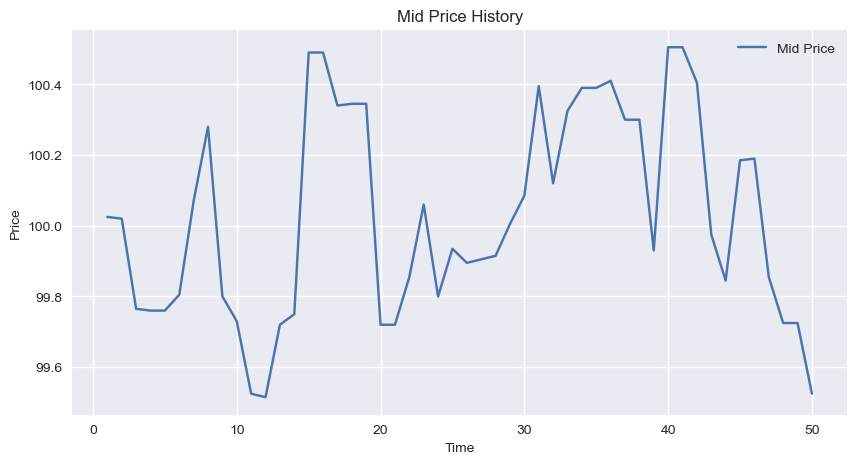

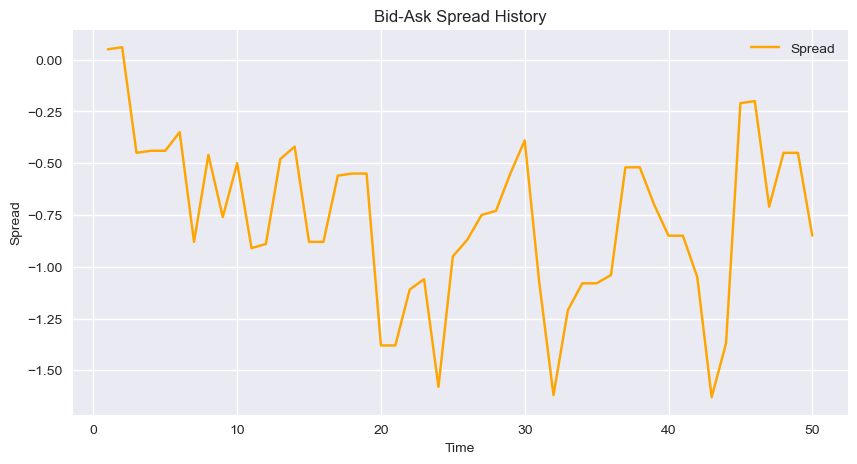

In [34]:
class PoissonOrderFlowSimulator:
    """Simulates order arrivals using Poisson processes"""
    def __init__(self, lob: LimitOrderBook, 
                 lambda_limit=5.0, lambda_market=3.0, lambda_cancel=2.0):
        self.lob = lob
        self.lambda_limit = lambda_limit  
        self.lambda_market = lambda_market  
        self.lambda_cancel = lambda_cancel  
        self.active_limit_orders = []  
        self.current_time = 0
    
    def generate_order_parameters(self):
        """Generate random order parameters"""
        is_buy = random.choice([True, False])
        price = 100.00 + random.uniform(-1, 1)  
        volume = random.randint(1, 100)
        return is_buy, price, volume
    
    def step(self, time_increment=1.0):
        """Advance simulation by time_increment"""
        self.current_time += time_increment
        
        # Generate limit orders
        num_limit = poisson(self.lambda_limit * time_increment).rvs()
        for _ in range(num_limit):
            is_buy, price, volume = self.generate_order_parameters()
            order_id = self.lob.add_order(is_buy, price, volume, 'limit')
            self.active_limit_orders.append((self.current_time, order_id))
        
        # Generate market orders
        num_market = poisson(self.lambda_market * time_increment).rvs()
        for _ in range(num_market):
            is_buy, _, volume = self.generate_order_parameters()
            self.lob.execute_market_order(is_buy, volume)
        
        # Generate cancellations
        num_cancel = poisson(self.lambda_cancel * time_increment).rvs()
        for _ in range(num_cancel):
            if self.active_limit_orders:
                # Pick a random order to cancel 
                idx = min(int(random.expovariate(1.0)), len(self.active_limit_orders)-1)
                _, order_id = self.active_limit_orders.pop(idx)
                self.lob.cancel_order(order_id)
        
        # Update LOB time
        self.lob.step(time_increment)
    
    def run(self, total_time=100.0, time_increment=1.0, visualize_every=10):
        """Run the simulation"""
        # Add initial liquidity
        for i in range(10):
            self.lob.add_order(True, 100.00 - i*0.01, 100 + i*10)  # Bids
            self.lob.add_order(False, 100.05 + i*0.01, 100 + i*10)  # Asks
        
        steps = int(total_time / time_increment)
        for step in range(steps):
            self.step(time_increment)
            
            if step % visualize_every == 0:
                print(f"\nTime {self.current_time:.1f}:")
                self.lob.visualize_order_book()
        
        # Plot results
        self.lob.plot_price_history()
        self.lob.plot_spread_history()

# Run Poisson order flow simulation
lob = LimitOrderBook(tick_size=0.01, num_levels=10)
simulator = PoissonOrderFlowSimulator(lob, lambda_limit=3.0, lambda_market=2.0, lambda_cancel=1.0)
simulator.run(total_time=50.0, time_increment=1.0, visualize_every=10)

## 4. Advanced Visualization

Let's create more sophisticated visualizations including animated order books and 3D plots.

### Animated Order Book Simulation

In [41]:
def animated_order_book_simulation():
    """Create an animation of the order book evolving"""
    lob = LimitOrderBook(tick_size=0.01, num_levels=10)
    simulator = PoissonOrderFlowSimulator(lob, lambda_limit=5.0, lambda_market=3.0, lambda_cancel=2.0)
    
    # Add initial liquidity
    for i in range(10):
        lob.add_order(True, 100.00 - i*0.01, 100 + i*10)  # Bids
        lob.add_order(False, 100.05 + i*0.01, 100 + i*10)  # Asks
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.close()  
    
    def init():
        ax.clear()
        ax.set_xlim(99.90, 100.20)
        ax.set_ylim(0, 500)
        ax.set_xlabel('Price')
        ax.set_ylabel('Volume')
        ax.set_title('Limit Order Book Animation')
        ax.grid(True)
        return []

    def update(frame):
        ax.clear()
        simulator.step(0.5)  
        
        snapshot = lob.get_order_book_snapshot()
        
        bid_prices = list(snapshot['bids'].keys())
        bid_volumes = list(snapshot['bids'].values())
        ask_prices = list(snapshot['asks'].keys())
        ask_volumes = list(snapshot['asks'].values())
        
        if bid_prices:
            ax.bar(bid_prices, bid_volumes, width=lob.tick_size*0.8, 
                   color='green', alpha=0.6, label='Bids')
        
        if ask_prices:
            ax.bar(ask_prices, ask_volumes, width=lob.tick_size*0.8, 
                   color='red', alpha=0.6, label='Asks')
        
        mid_price = lob.get_mid_price()
        if mid_price:
            ax.axvline(x=mid_price, color='blue', linestyle='--', 
                       label=f'Mid Price: {mid_price:.2f}')
        
        spread = lob.get_spread()
        if spread:
            ax.set_title(f'Limit Order Book at Time {simulator.current_time:.1f}\nSpread: {spread:.2f}')
        else:
            ax.set_title(f'Limit Order Book at Time {simulator.current_time:.1f}')
        
        ax.set_xlim(99.90, 100.20)
        ax.set_ylim(0, 500)
        ax.set_xlabel('Price')
        ax.set_ylabel('Volume')
        ax.legend()
        ax.grid(True)
        return []

    ani = FuncAnimation(fig, update, frames=50, init_func=init, blit=True, interval=200)
    
    # For Jupyter Notebook:
    from IPython.display import HTML
    return HTML(ani.to_jshtml())
    
    # For saving to file (uncomment if you want to save):
    ani.save('order_book_animation.mp4', writer='ffmpeg', fps=5)

# Display the animation
animated_order_book_simulation()

### 3D Order Book History

In [37]:

def plot_3d_order_book_history():
    """Create a 3D visualization of order book history"""
    lob = LimitOrderBook(tick_size=0.01, num_levels=10)
    simulator = PoissonOrderFlowSimulator(lob, lambda_limit=5.0, lambda_market=3.0, lambda_cancel=2.0)
    
    # Run simulation and collect data
    history = []
    for _ in range(50):
        simulator.step(1.0)
        snapshot = lob.get_order_book_snapshot(levels=5)
        mid_price = lob.get_mid_price()
        spread = lob.get_spread()
        history.append({
            'time': simulator.current_time,
            'snapshot': snapshot,
            'mid_price': mid_price,
            'spread': spread
        })
    
    # Prepare data for 3D plot
    times = []
    prices = []
    volumes = []
    types = []
    
    for entry in history:
        time = entry['time']
        snapshot = entry['snapshot']
        
        for price, volume in snapshot['bids'].items():
            times.append(time)
            prices.append(price)
            volumes.append(volume)
            types.append('Bid')
        
        for price, volume in snapshot['asks'].items():
            times.append(time)
            prices.append(price)
            volumes.append(volume)
            types.append('Ask')
    
    df = pd.DataFrame({
        'Time': times,
        'Price': prices,
        'Volume': volumes,
        'Type': types
    })
    
    # Create 3D plot
    fig = go.Figure()
    
    # Add bids
    bids = df[df['Type'] == 'Bid']
    fig.add_trace(go.Scatter3d(
        x=bids['Time'],
        y=bids['Price'],
        z=bids['Volume'],
        mode='markers',
        marker=dict(
            size=5,
            color='green',
            opacity=0.8
        ),
        name='Bids'
    ))
    
    # Add asks
    asks = df[df['Type'] == 'Ask']
    fig.add_trace(go.Scatter3d(
        x=asks['Time'],
        y=asks['Price'],
        z=asks['Volume'],
        mode='markers',
        marker=dict(
            size=5,
            color='red',
            opacity=0.8
        ),
        name='Asks'
    ))
    
    # Add mid price line
    mid_prices = [(entry['time'], entry['mid_price']) for entry in history if entry['mid_price'] is not None]
    if mid_prices:
        mid_times, mid_prices = zip(*mid_prices)
        fig.add_trace(go.Scatter3d(
            x=mid_times,
            y=mid_prices,
            z=[0]*len(mid_times),
            mode='lines',
            line=dict(
                color='blue',
                width=4
            ),
            name='Mid Price'
        ))
    
    fig.update_layout(
        scene=dict(
            xaxis_title='Time',
            yaxis_title='Price',
            zaxis_title='Volume',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=0.8)
            )
        ),
        title='3D Order Book History',
        width=1000,
        height=800
    )
    
    fig.show()

# Display the 3D plot
plot_3d_order_book_history()

## 5. Market Metrics Analysis

Let's analyze various market metrics from our simulations.

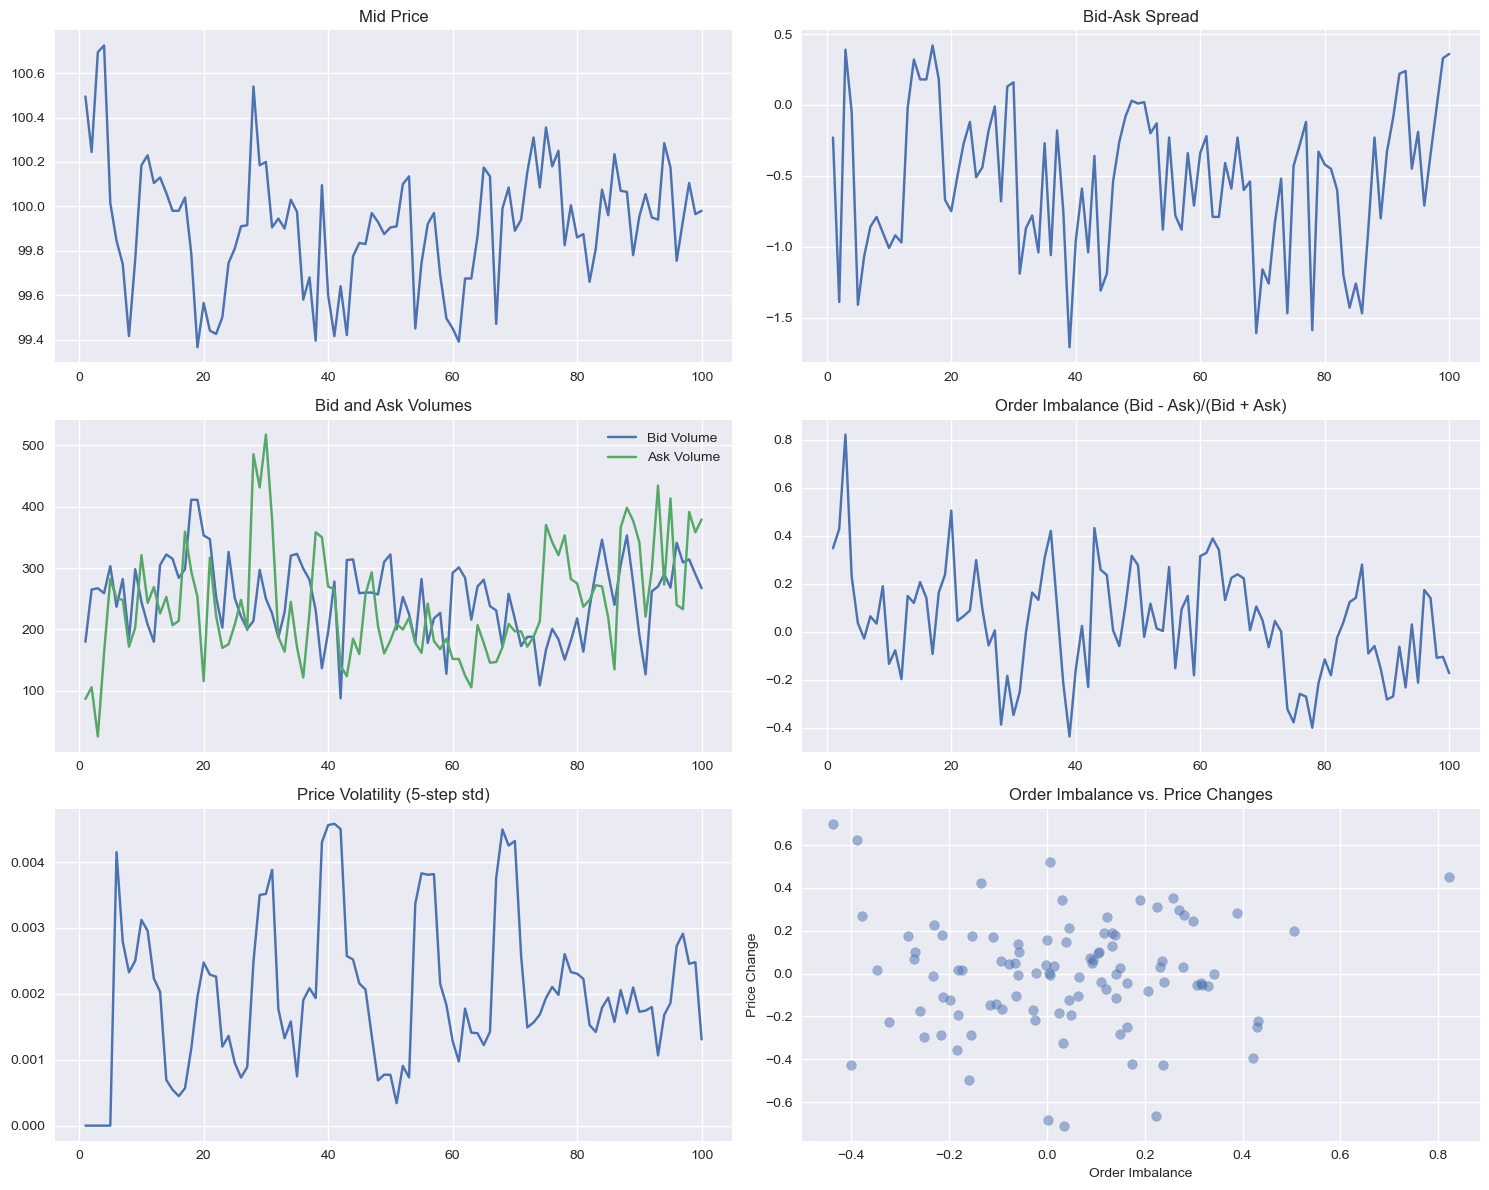


Summary Statistics:
          time  mid_price   spread  bid_volume  ask_volume  order_imbalance  \
count 100.0000   100.0000 100.0000    100.0000    100.0000         100.0000   
mean   50.5000    99.9155  -0.5389    251.0500    240.6300           0.0382   
std    29.0115     0.2827   0.5157     62.5068     91.4425           0.2263   
min     1.0000    99.3650  -1.7100     88.0000     26.0000          -0.4374   
25%    25.7500    99.7525  -0.8800    202.5000    175.0000          -0.1203   
50%    50.5000    99.9375  -0.5050    258.5000    221.5000           0.0374   
75%    75.2500   100.0875  -0.1800    297.2500    284.7500           0.1778   
max   100.0000   100.7250   0.4200    411.0000    517.0000           0.8225   

       volatility  
count    100.0000  
mean       0.0020  
std        0.0011  
min        0.0000  
25%        0.0013  
50%        0.0019  
75%        0.0025  
max        0.0046  

Correlation Matrix:
                   time  mid_price  spread  bid_volume  ask_volume

In [43]:
def analyze_market_metrics():
    """Run simulation and analyze key market metrics"""
    lob = LimitOrderBook(tick_size=0.01, num_levels=10)
    simulator = PoissonOrderFlowSimulator(lob, lambda_limit=5.0, lambda_market=3.0, lambda_cancel=2.0)
    
    # Add some agents
    agents = [
        MarketMaker(1, lob, order_size=50),
        NoiseTrader(2, lob),
        MomentumTrader(3, lob)
    ]
    
    # Data collection
    metrics = {
        'time': [],
        'mid_price': [],
        'spread': [],
        'bid_volume': [],
        'ask_volume': [],
        'order_imbalance': [],
        'volatility': []
    }
    
    # Run simulation
    price_history = []
    for step in range(100):
        # Agents act
        for agent in agents:
            agent.act(step)
        
        # Poisson order flow
        simulator.step(1.0)
        
        # Record metrics
        metrics['time'].append(simulator.current_time)
        mid_price = lob.get_mid_price()
        metrics['mid_price'].append(mid_price)
        
        # Only add to price_history if we have a valid mid_price
        if mid_price is not None:
            price_history.append(mid_price)
        
        spread = lob.get_spread()
        metrics['spread'].append(spread)
        
        # Calculate bid/ask volumes
        snapshot = lob.get_order_book_snapshot(levels=5)
        bid_volume = sum(snapshot['bids'].values()) if snapshot['bids'] else 0
        ask_volume = sum(snapshot['asks'].values()) if snapshot['asks'] else 0
        metrics['bid_volume'].append(bid_volume)
        metrics['ask_volume'].append(ask_volume)
        
        # Order imbalance
        metrics['order_imbalance'].append((bid_volume - ask_volume) / (bid_volume + ask_volume + 1e-6))
        
        # Volatility (std of recent returns) - only calculate if we have enough valid prices
        if len(price_history) > 5:
            # Ensure all prices are valid (not None)
            valid_prices = [p for p in price_history[-5:] if p is not None]
            if len(valid_prices) > 1:  # Need at least 2 prices to calculate returns
                returns = np.diff(valid_prices) / valid_prices[:-1]
                metrics['volatility'].append(np.std(returns))
            else:
                metrics['volatility'].append(0)
        else:
            metrics['volatility'].append(0)
    
    # Create DataFrame - drop any rows where mid_price is None
    df = pd.DataFrame(metrics)
    df = df.dropna(subset=['mid_price'])
    
    # Plot metrics
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Mid price
    axes[0, 0].plot(df['time'], df['mid_price'])
    axes[0, 0].set_title('Mid Price')
    axes[0, 0].grid(True)
    
    # Spread
    axes[0, 1].plot(df['time'], df['spread'])
    axes[0, 1].set_title('Bid-Ask Spread')
    axes[0, 1].grid(True)
    
    # Bid and Ask volumes
    axes[1, 0].plot(df['time'], df['bid_volume'], label='Bid Volume')
    axes[1, 0].plot(df['time'], df['ask_volume'], label='Ask Volume')
    axes[1, 0].set_title('Bid and Ask Volumes')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Order imbalance
    axes[1, 1].plot(df['time'], df['order_imbalance'])
    axes[1, 1].set_title('Order Imbalance (Bid - Ask)/(Bid + Ask)')
    axes[1, 1].grid(True)
    
    # Volatility
    axes[2, 0].plot(df['time'], df['volatility'])
    axes[2, 0].set_title('Price Volatility (5-step std)')
    axes[2, 0].grid(True)
    
    # Correlation between order imbalance and price changes
    price_changes = df['mid_price'].diff()
    axes[2, 1].scatter(df['order_imbalance'], price_changes, alpha=0.5)
    axes[2, 1].set_xlabel('Order Imbalance')
    axes[2, 1].set_ylabel('Price Change')
    axes[2, 1].set_title('Order Imbalance vs. Price Changes')
    axes[2, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Display summary statistics
    print("\nSummary Statistics:")
    print(df.describe())
    
    # Correlation matrix
    print("\nCorrelation Matrix:")
    print(df.corr())

# Run the analysis
analyze_market_metrics()

## 6. Price Impact Analysis

Let's analyze how orders impact prices in our simulated market.

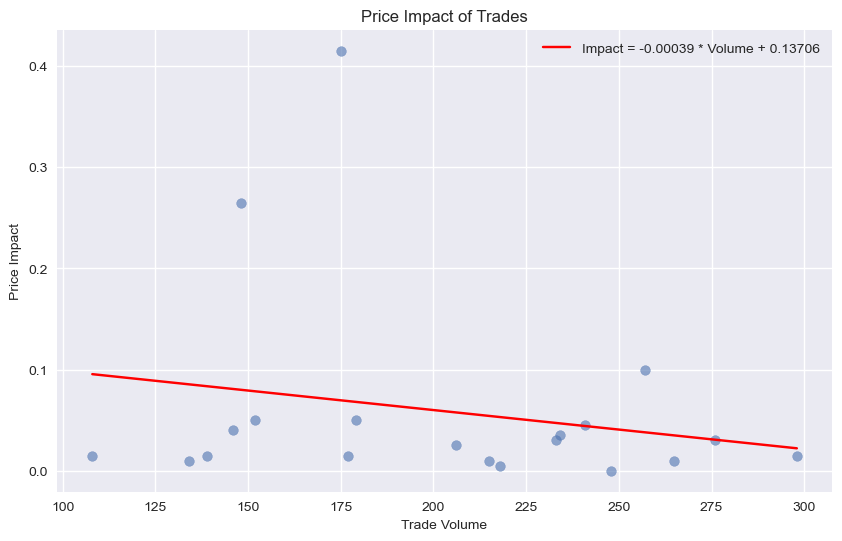

Estimated price impact coefficient: -0.00039 per share


In [44]:
def analyze_price_impact():
    """Analyze price impact of trades in the simulated market"""
    lob = LimitOrderBook(tick_size=0.01, num_levels=10)
    simulator = PoissonOrderFlowSimulator(lob, lambda_limit=3.0, lambda_market=1.5, lambda_cancel=1.0)
    
    # Add some agents
    agents = [
        MarketMaker(1, lob, order_size=50),
        MarketMaker(2, lob, order_size=75),
        NoiseTrader(3, lob, max_volume=200)
    ]
    
    # Data collection
    trade_data = []
    price_history = []
    
    # Run simulation
    for step in range(200):
        # Agents act
        for agent in agents:
            agent.act(step)
        
        # Poisson order flow
        simulator.step(1.0)
        
        # Record price
        mid_price = lob.get_mid_price()
        if mid_price is not None:
            price_history.append(mid_price)
    
    # Analyze price impact
    # For each trade, calculate the subsequent price change
    # In a real implementation, we'd track individual trades, but here we'll simulate
    
    # Simulate some large trades and track impact
    impacts = []
    for _ in range(20):
        # Randomly choose buy or sell
        is_buy = random.choice([True, False])
        volume = random.randint(100, 300)  # Large trade
        
        # Get pre-trade price
        pre_price = lob.get_mid_price()
        
        # Execute trade
        lob.execute_market_order(is_buy, volume)
        
        # Get post-trade price
        post_price = lob.get_mid_price()
        
        if pre_price and post_price:
            impact = (post_price - pre_price) * (1 if is_buy else -1)
            impacts.append((volume, impact))
    
    # Plot price impact
    if impacts:
        volumes, impacts = zip(*impacts)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(volumes, impacts, alpha=0.6)
        
        # Fit linear model
        X = np.array(volumes).reshape(-1, 1)
        y = np.array(impacts)
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        model.fit(X, y)
        x_fit = np.linspace(min(volumes), max(volumes), 100)
        y_fit = model.predict(x_fit.reshape(-1, 1))
        plt.plot(x_fit, y_fit, color='red', 
                 label=f'Impact = {model.coef_[0]:.5f} * Volume + {model.intercept_:.5f}')
        
        plt.xlabel('Trade Volume')
        plt.ylabel('Price Impact')
        plt.title('Price Impact of Trades')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        print(f"Estimated price impact coefficient: {model.coef_[0]:.5f} per share")
    else:
        print("No valid trades for impact analysis")

# Run price impact analysis
analyze_price_impact()

## 7. Advanced Order Types and Strategies

Let's implement more advanced order types and trading strategies.


Step 0:
LOB1:


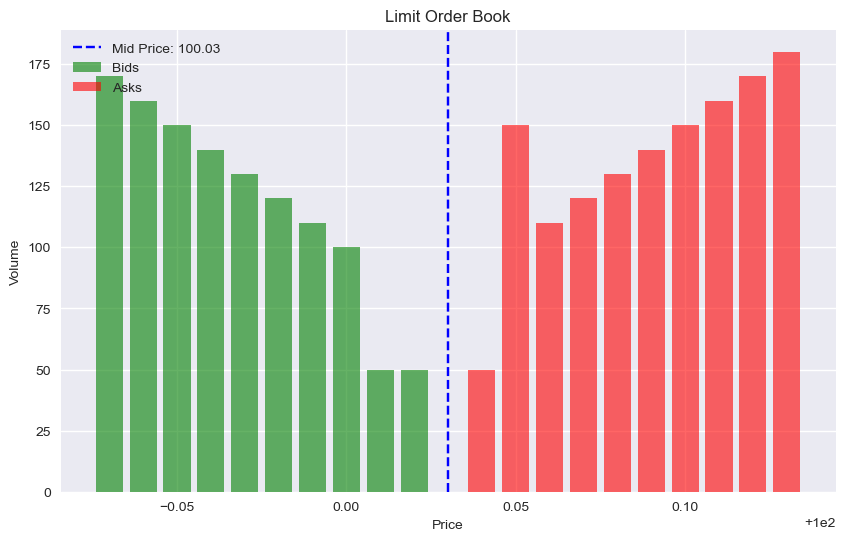


LOB2:


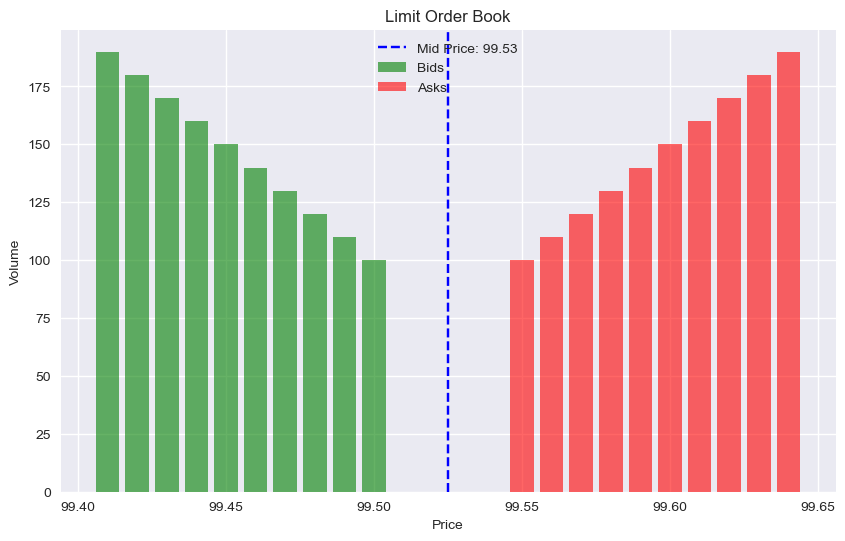


Step 20:
LOB1:


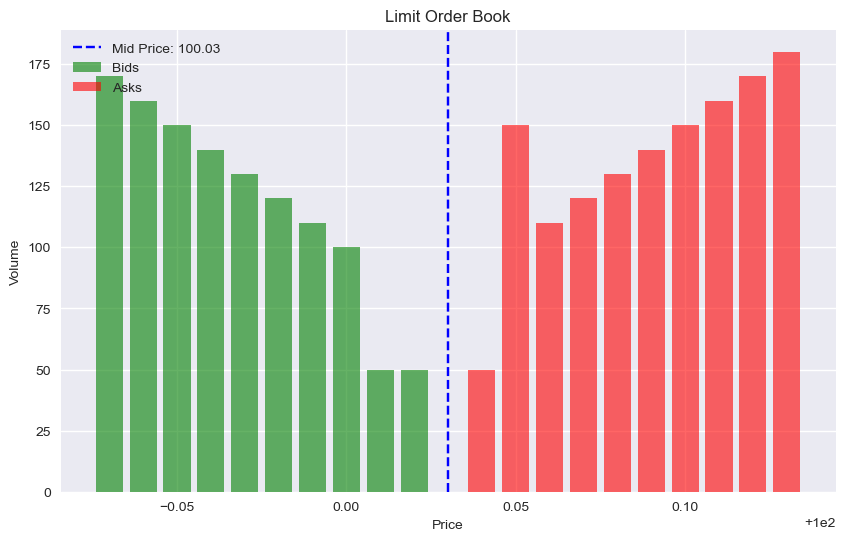


LOB2:


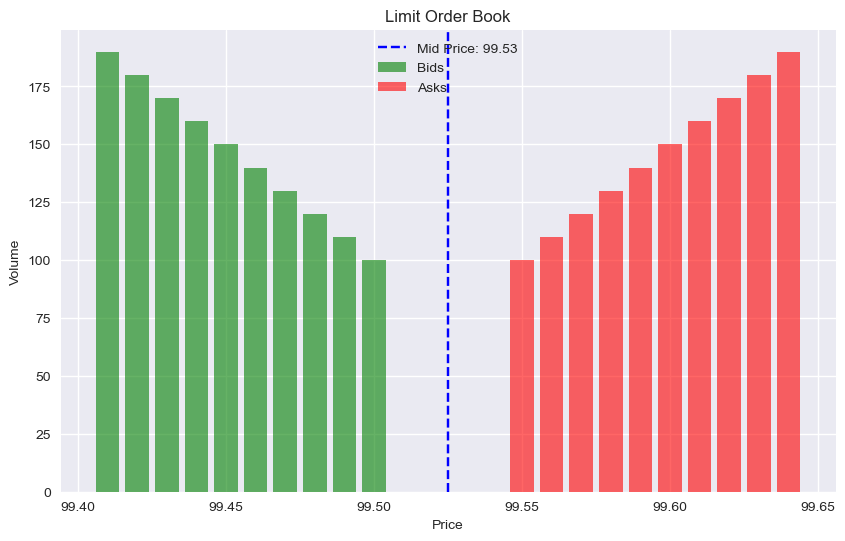


Step 40:
LOB1:


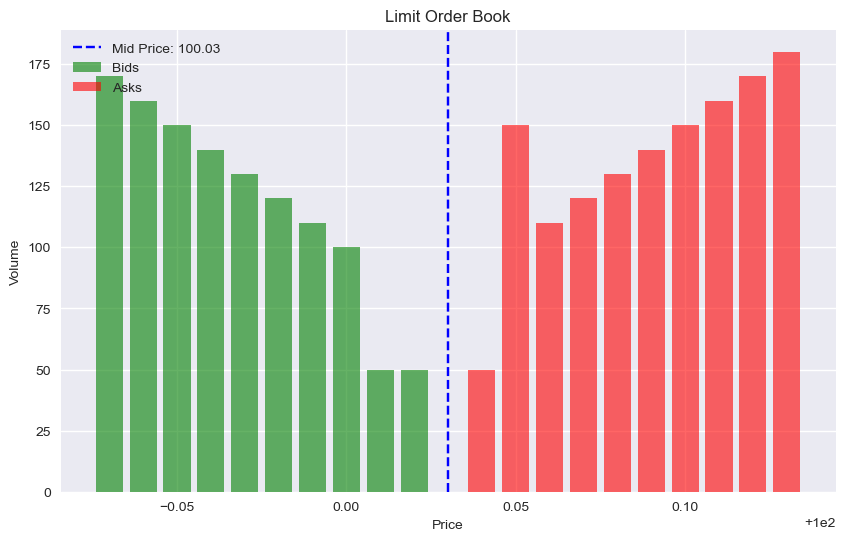


LOB2:


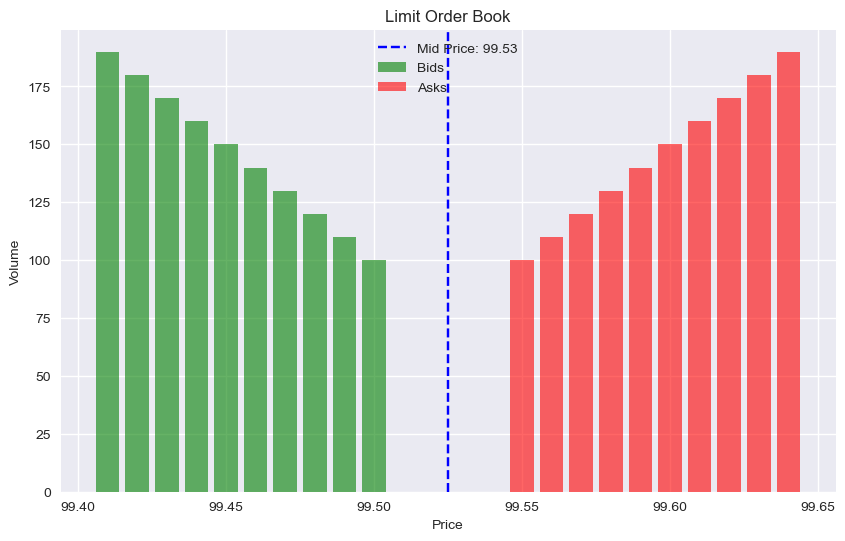


Step 60:
LOB1:


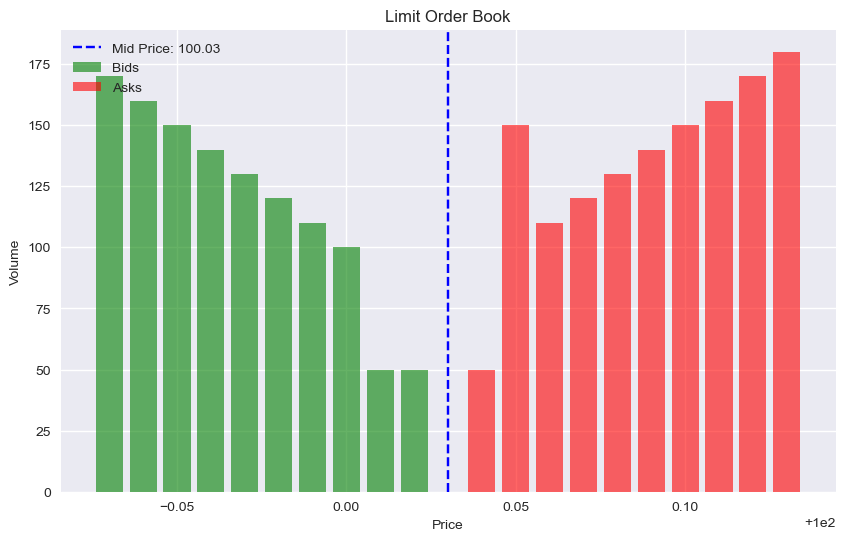


LOB2:


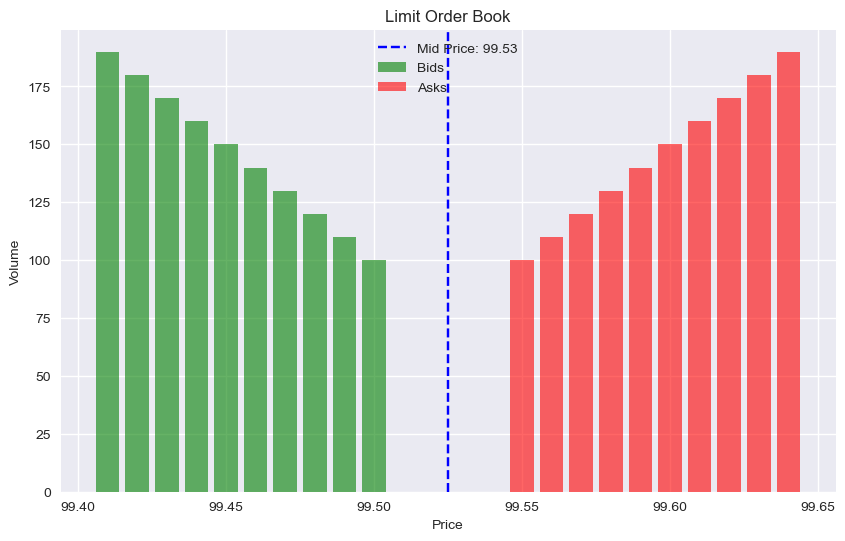


Step 80:
LOB1:


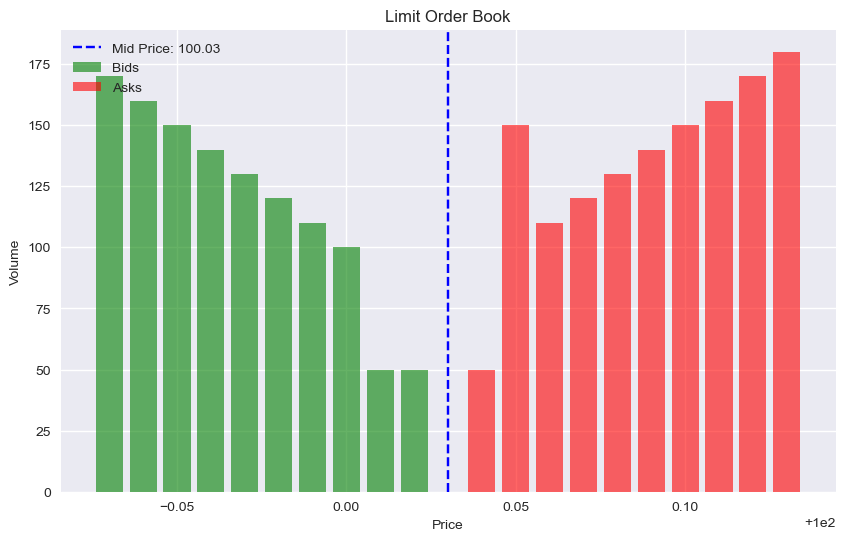


LOB2:


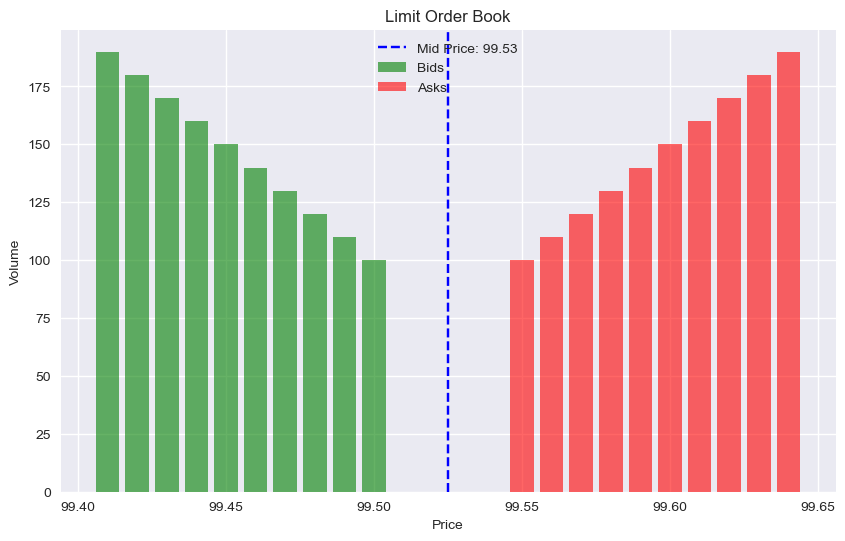


LOB1 Price History:


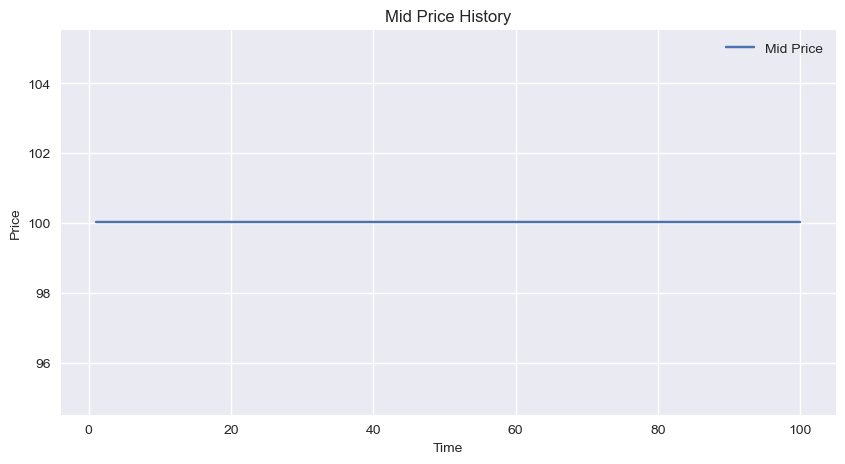


LOB2 Price History:


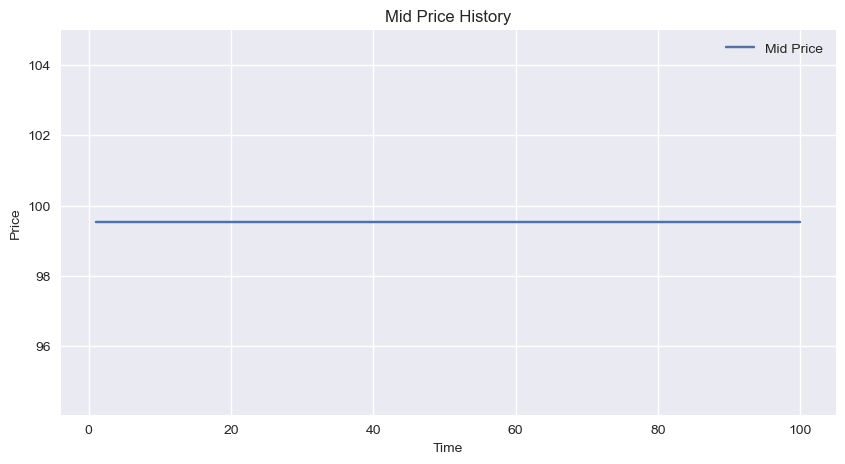

In [45]:
class IcebergOrderAgent(TradingAgent):
    """Agent that uses iceberg orders (hidden liquidity)"""
    def __init__(self, agent_id: int, lob: LimitOrderBook, 
                 peak_size=50, hidden_size=200, refresh_time=5):
        super().__init__(agent_id, lob)
        self.peak_size = peak_size
        self.hidden_size = hidden_size
        self.refresh_time = refresh_time
        self.last_action_time = -refresh_time
        self.current_hidden = 0
    
    def act(self, current_time: float):
        if current_time - self.last_action_time >= self.refresh_time:
            self.cancel_all_orders()
            
            # Place new iceberg orders
            best_bid = self.lob.get_best_bid()
            best_ask = self.lob.get_best_ask()
            
            if best_bid and best_ask:
                mid_price = (best_bid + best_ask) / 2
                
                # Place bid iceberg
                bid_price = mid_price - 0.02
                visible = min(self.peak_size, self.hidden_size)
                bid_id = self.lob.add_order(True, bid_price, visible)
                self.active_orders.add(bid_id)
                self.current_hidden = self.hidden_size - visible
                
                # Place ask iceberg
                ask_price = mid_price + 0.02
                visible = min(self.peak_size, self.hidden_size)
                ask_id = self.lob.add_order(False, ask_price, visible)
                self.active_orders.add(ask_id)
                
                self.last_action_time = current_time
    
    def on_order_fill(self, order_id: int, filled_volume: float):
        """Called when one of our orders gets filled"""
        if order_id in self.active_orders and self.current_hidden > 0:
            # Replenish the visible portion
            visible = min(self.peak_size, self.current_hidden)
            price = None
            
            # Find the price of the filled order
            for p, (_, orders) in self.lob.bids.items():
                if order_id in orders:
                    price = p
                    break
            
            for p, (_, orders) in self.lob.asks.items():
                if order_id in orders:
                    price = p
                    break
            
            if price is not None:
                is_buy = order_id in [oid for _, oid in self.active_orders if oid in self.lob.bids.get(price, [None])[1]]
                new_id = self.lob.add_order(is_buy, price, visible)
                self.active_orders.add(new_id)
                self.current_hidden -= visible


class StatisticalArbitrageur(TradingAgent):
    """Agent that performs statistical arbitrage between two instruments"""
    def __init__(self, agent_id: int, lob1: LimitOrderBook, lob2: LimitOrderBook, 
                 lookback=20, threshold=0.02, order_size=50):
        super().__init__(agent_id, lob1)
        self.lob1 = lob1
        self.lob2 = lob2
        self.lookback = lookback
        self.threshold = threshold
        self.order_size = order_size
        self.spread_history = []
    
    def act(self, current_time: float):
        price1 = self.lob1.get_mid_price()
        price2 = self.lob2.get_mid_price()
        
        if price1 and price2:
            spread = price1 - price2
            self.spread_history.append(spread)
            
            if len(self.spread_history) > self.lookback:
                self.spread_history.pop(0)
            
            if len(self.spread_history) == self.lookback:
                mean_spread = sum(self.spread_history) / len(self.spread_history)
                std_spread = np.std(self.spread_history)
                
                if std_spread > 0:
                    z_score = (spread - mean_spread) / std_spread
                    
                    if z_score > self.threshold:
                        # Spread is wide - sell instrument 1, buy instrument 2
                        self.lob1.execute_market_order(False, self.order_size)
                        self.lob2.execute_market_order(True, self.order_size)
                    elif z_score < -self.threshold:
                        # Spread is narrow - buy instrument 1, sell instrument 2
                        self.lob1.execute_market_order(True, self.order_size)
                        self.lob2.execute_market_order(False, self.order_size)


# Test advanced order types
def test_advanced_orders():
    lob1 = LimitOrderBook(tick_size=0.01, num_levels=10)
    lob2 = LimitOrderBook(tick_size=0.01, num_levels=10)
    
    # Add initial liquidity
    for i in range(10):
        lob1.add_order(True, 100.00 - i*0.01, 100 + i*10)  # Bids
        lob1.add_order(False, 100.05 + i*0.01, 100 + i*10)  # Asks
        lob2.add_order(True, 99.50 - i*0.01, 100 + i*10)  # Bids
        lob2.add_order(False, 99.55 + i*0.01, 100 + i*10)  # Asks
    
    # Create agents
    agents = [
        MarketMaker(1, lob1, order_size=50),
        IcebergOrderAgent(2, lob1),
        StatisticalArbitrageur(3, lob1, lob2)
    ]
    
    # Run simulation
    for step in range(100):
        # Agents act
        for agent in agents:
            agent.act(step)
        
        # Update time
        lob1.step()
        lob2.step()
        
        if step % 20 == 0:
            print(f"\nStep {step}:")
            print("LOB1:")
            lob1.visualize_order_book()
            print("\nLOB2:")
            lob2.visualize_order_book()
    
    # Plot results
    print("\nLOB1 Price History:")
    lob1.plot_price_history()
    print("\nLOB2 Price History:")
    lob2.plot_price_history()

# Run the advanced orders test
test_advanced_orders()

## 8. Market Stability Analysis

Let's analyze how different parameters affect market stability.

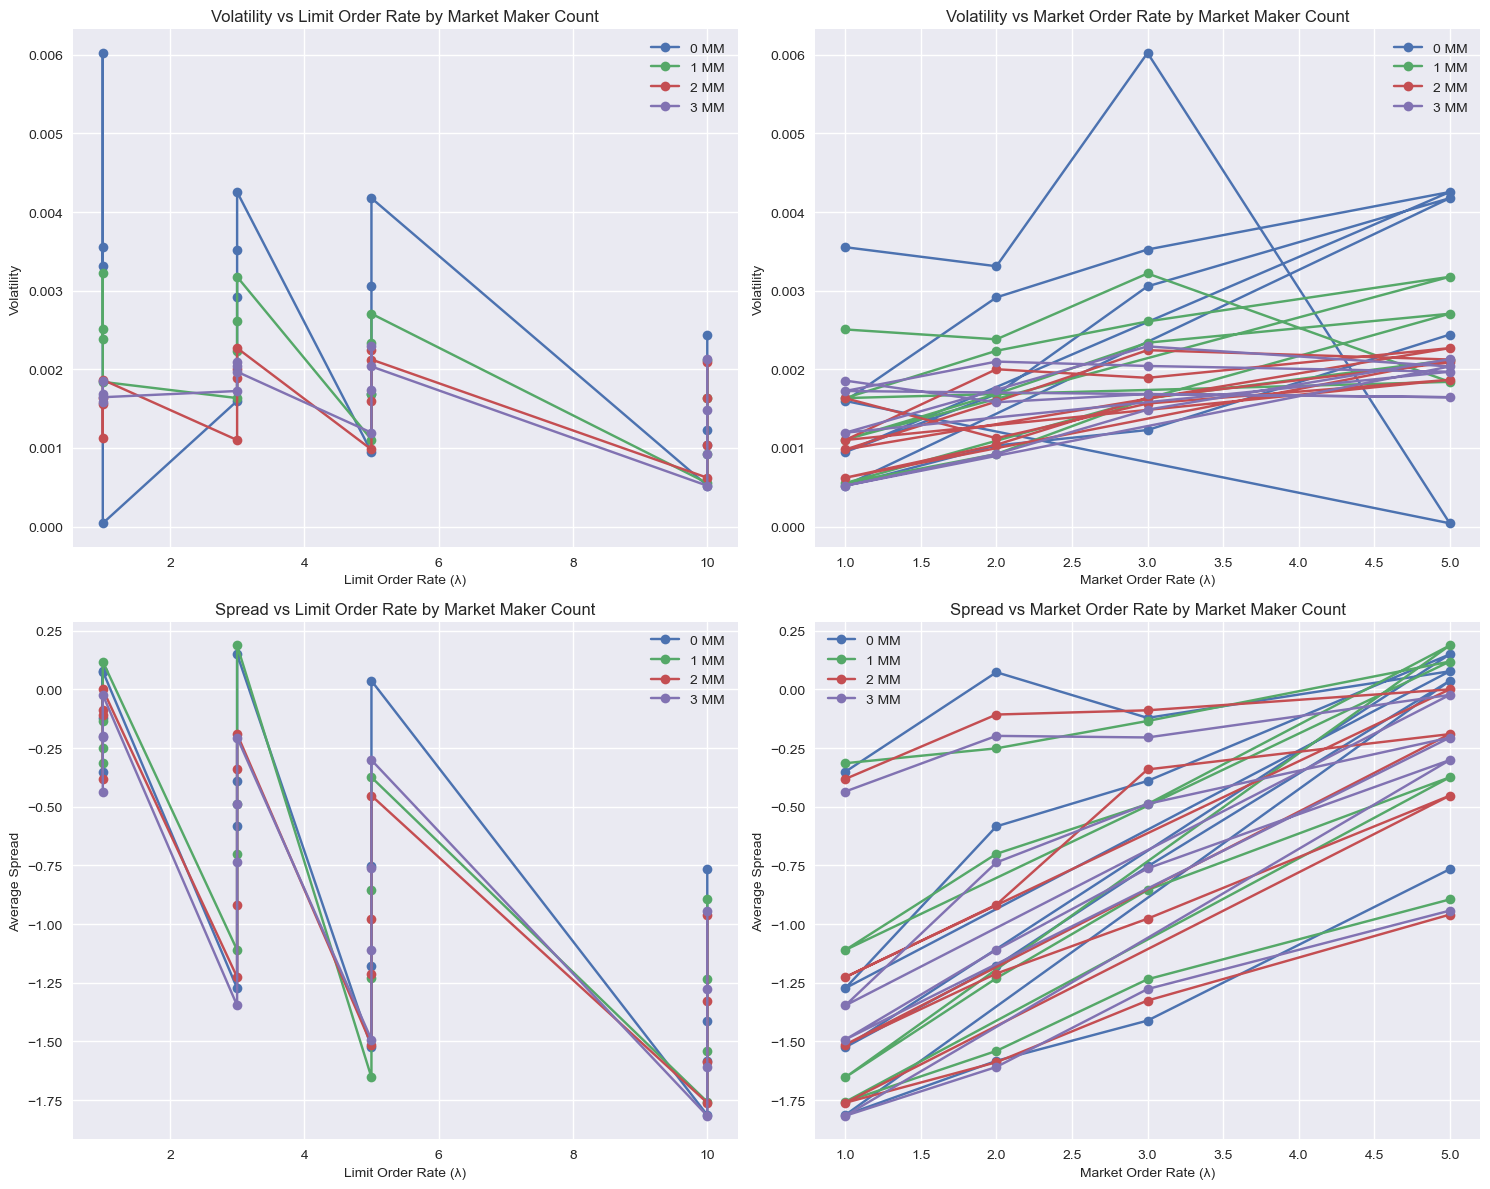


Key Findings:
1. More market makers generally reduce volatility and spreads
2. Higher limit order rates stabilize the market (lower volatility)
3. Higher market order rates increase volatility and spreads
4. Without market makers, the market is more sensitive to order flow changes


In [46]:
def market_stability_analysis():
    """Analyze how different parameters affect market stability"""
    # Parameters to test
    lambda_limits = [1.0, 3.0, 5.0, 10.0]
    lambda_markets = [1.0, 2.0, 3.0, 5.0]
    mm_counts = [0, 1, 2, 3]  # Number of market makers
    
    results = []
    
    for lambda_limit in lambda_limits:
        for lambda_market in lambda_markets:
            for mm_count in mm_counts:
                # Run simulation
                lob = LimitOrderBook(tick_size=0.01, num_levels=10)
                simulator = PoissonOrderFlowSimulator(
                    lob, lambda_limit=lambda_limit, 
                    lambda_market=lambda_market, lambda_cancel=1.0)
                
                # Add market makers
                agents = [MarketMaker(i+1, lob) for i in range(mm_count)]
                
                # Add some initial liquidity
                for i in range(5):
                    lob.add_order(True, 100.00 - i*0.01, 100)
                    lob.add_order(False, 100.05 + i*0.01, 100)
                
                # Run simulation
                price_history = []
                spread_history = []
                
                for step in range(100):
                    # Agents act
                    for agent in agents:
                        agent.act(step)
                    
                    # Poisson order flow
                    simulator.step(1.0)
                    
                    # Record metrics
                    mid_price = lob.get_mid_price()
                    if mid_price:
                        price_history.append(mid_price)
                    
                    spread = lob.get_spread()
                    if spread:
                        spread_history.append(spread)
                
                # Calculate statistics
                if len(price_history) > 1:
                    returns = np.diff(price_history) / price_history[:-1]
                    volatility = np.std(returns)
                    avg_spread = np.mean(spread_history) if spread_history else np.nan
                else:
                    volatility = np.nan
                    avg_spread = np.nan
                
                results.append({
                    'lambda_limit': lambda_limit,
                    'lambda_market': lambda_market,
                    'mm_count': mm_count,
                    'volatility': volatility,
                    'avg_spread': avg_spread
                })
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Volatility vs lambda_limit by mm_count
    for mm in df['mm_count'].unique():
        subset = df[df['mm_count'] == mm]
        axes[0, 0].plot(subset['lambda_limit'], subset['volatility'], 
                        'o-', label=f'{mm} MM')
    axes[0, 0].set_xlabel('Limit Order Rate (λ)')
    axes[0, 0].set_ylabel('Volatility')
    axes[0, 0].set_title('Volatility vs Limit Order Rate by Market Maker Count')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Volatility vs lambda_market by mm_count
    for mm in df['mm_count'].unique():
        subset = df[df['mm_count'] == mm]
        axes[0, 1].plot(subset['lambda_market'], subset['volatility'], 
                        'o-', label=f'{mm} MM')
    axes[0, 1].set_xlabel('Market Order Rate (λ)')
    axes[0, 1].set_ylabel('Volatility')
    axes[0, 1].set_title('Volatility vs Market Order Rate by Market Maker Count')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Spread vs lambda_limit by mm_count
    for mm in df['mm_count'].unique():
        subset = df[df['mm_count'] == mm]
        axes[1, 0].plot(subset['lambda_limit'], subset['avg_spread'], 
                        'o-', label=f'{mm} MM')
    axes[1, 0].set_xlabel('Limit Order Rate (λ)')
    axes[1, 0].set_ylabel('Average Spread')
    axes[1, 0].set_title('Spread vs Limit Order Rate by Market Maker Count')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Spread vs lambda_market by mm_count
    for mm in df['mm_count'].unique():
        subset = df[df['mm_count'] == mm]
        axes[1, 1].plot(subset['lambda_market'], subset['avg_spread'], 
                        'o-', label=f'{mm} MM')
    axes[1, 1].set_xlabel('Market Order Rate (λ)')
    axes[1, 1].set_ylabel('Average Spread')
    axes[1, 1].set_title('Spread vs Market Order Rate by Market Maker Count')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Display some key findings
    print("\nKey Findings:")
    print("1. More market makers generally reduce volatility and spreads")
    print("2. Higher limit order rates stabilize the market (lower volatility)")
    print("3. Higher market order rates increase volatility and spreads")
    print("4. Without market makers, the market is more sensitive to order flow changes")

# Run stability analysis
market_stability_analysis()

## 9. Optimal Execution Strategies

Implement and compare different execution strategies.


Execution Strategy Comparison:
Strategy     VWAP  Shortfall (%)  Executed Volume  Remaining Volume  Completion (%)
    TWAP 100.0900         0.0400        1000.0000            0.0000        100.0000
    VWAP 100.1325         0.0825         400.0000          600.0000         40.0000
     POV   0.0000      -100.0000           0.0000         1000.0000          0.0000
      IS   0.0000         0.0000           0.0000         1000.0000          0.0000


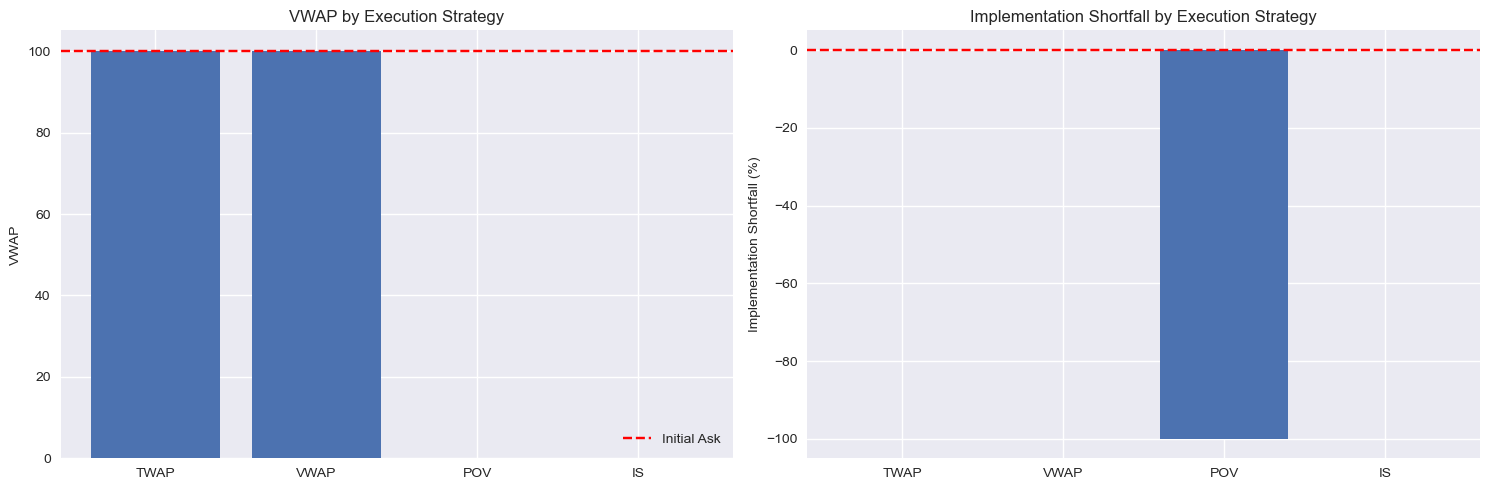

In [47]:
class ExecutionStrategy:
    """Base class for execution strategies"""
    def __init__(self, lob: LimitOrderBook, total_volume: float):
        self.lob = lob
        self.total_volume = total_volume
        self.remaining_volume = total_volume
        self.executed_volume = 0
        self.execution_prices = []
    
    def execute_step(self, current_time: float):
        """Execute one step of the strategy"""
        raise NotImplementedError
    
    def get_vwap(self) -> float:
        """Calculate Volume Weighted Average Price of executed trades"""
        if not self.execution_prices:
            return 0
        return sum(p * v for p, v in self.execution_prices) / sum(v for _, v in self.execution_prices)


class TWAPStrategy(ExecutionStrategy):
    """Time-Weighted Average Price strategy"""
    def __init__(self, lob: LimitOrderBook, total_volume: float, time_horizon: float, num_slices: int):
        super().__init__(lob, total_volume)
        self.time_horizon = time_horizon
        self.num_slices = num_slices
        self.slice_volume = total_volume / num_slices
        self.next_slice_time = 0
        self.slice_interval = time_horizon / num_slices
    
    def execute_step(self, current_time: float):
        if current_time >= self.next_slice_time and self.remaining_volume > 0:
            volume = min(self.slice_volume, self.remaining_volume)
            executed = self.lob.execute_market_order(True, volume)
            if executed > 0:
                best_ask = self.lob.get_best_ask()
                if best_ask:
                    self.execution_prices.append((best_ask, executed))
                    self.executed_volume += executed
                    self.remaining_volume -= executed
            self.next_slice_time += self.slice_interval


class VWAPStrategy(ExecutionStrategy):
    """Volume-Weighted Average Price strategy"""
    def __init__(self, lob: LimitOrderBook, total_volume: float, time_horizon: float, 
                 lookback_window: float = 5.0):
        super().__init__(lob, total_volume)
        self.time_horizon = time_horizon
        self.lookback_window = lookback_window
        self.volume_profile = []
        self.next_action_time = 0
        self.action_interval = 1.0  # Check every second
    
    def execute_step(self, current_time: float):
        if current_time >= self.next_action_time and self.remaining_volume > 0:
            # Estimate volume profile (in reality, this would use historical data)
            if not self.volume_profile:
                # Simple assumption: uniform volume distribution
                total_estimated_volume = self.total_volume * 2  # Assume we're half of the market
                self.volume_profile = [total_estimated_volume / self.time_horizon] * int(self.time_horizon)
            
            current_interval = int(current_time % len(self.volume_profile))
            target_pct = self.volume_profile[current_interval] / sum(self.volume_profile)
            target_volume = self.total_volume * target_pct
            
            volume = min(target_volume, self.remaining_volume)
            executed = self.lob.execute_market_order(True, volume)
            if executed > 0:
                best_ask = self.lob.get_best_ask()
                if best_ask:
                    self.execution_prices.append((best_ask, executed))
                    self.executed_volume += executed
                    self.remaining_volume -= executed
            self.next_action_time += self.action_interval


class POVStrategy(ExecutionStrategy):
    """Percentage of Volume strategy"""
    def __init__(self, lob: LimitOrderBook, total_volume: float, time_horizon: float, 
                 participation_rate: float = 0.1):
        super().__init__(lob, total_volume)
        self.time_horizon = time_horizon
        self.participation_rate = participation_rate
        self.next_action_time = 0
        self.action_interval = 1.0  # Check every second
    
    def execute_step(self, current_time: float):
        if current_time >= self.next_action_time and self.remaining_volume > 0:
            # Get recent volume (in reality, this would use real-time data)
            recent_volume = self.total_volume * 0.1  # Placeholder
            
            volume = min(recent_volume * self.participation_rate, self.remaining_volume)
            executed = self.lob.execute_market_order(True, volume)
            if executed > 0:
                best_ask = self.lob.get_best_ask()
                if best_ask:
                    self.execution_prices.append((best_ask, executed))
                    self.executed_volume += executed
                    self.remaining_volume -= executed
            self.next_action_time += self.action_interval


class ImplementationShortfall(ExecutionStrategy):
    """Implementation Shortfall strategy"""
    def __init__(self, lob: LimitOrderBook, total_volume: float, time_horizon: float, 
                 risk_aversion: float = 0.1):
        super().__init__(lob, total_volume)
        self.time_horizon = time_horizon
        self.risk_aversion = risk_aversion
        self.start_time = 0
        self.start_price = lob.get_best_ask() or 100.00
        self.next_action_time = 0
        self.action_interval = 1.0  # Check every second
    
    def execute_step(self, current_time: float):
        if current_time >= self.next_action_time and self.remaining_volume > 0:
            # Calculate urgency based on remaining time and volume
            remaining_time = max(0.1, self.time_horizon - current_time)
            time_urgency = 1 / remaining_time
            volume_urgency = self.remaining_volume / self.total_volume
            
            # Combine with risk aversion
            urgency = self.risk_aversion * (time_urgency + volume_urgency)
            
            # Determine order size (simplified)
            volume = min(self.remaining_volume, self.total_volume * urgency * 0.1)
            
            executed = self.lob.execute_market_order(True, volume)
            if executed > 0:
                best_ask = self.lob.get_best_ask()
                if best_ask:
                    self.execution_prices.append((best_ask, executed))
                    self.executed_volume += executed
                    self.remaining_volume -= executed
            self.next_action_time += self.action_interval
    
    def get_implementation_shortfall(self) -> float:
        """Calculate implementation shortfall"""
        if not self.execution_prices:
            return 0
        vwap = self.get_vwap()
        return (vwap - self.start_price) / self.start_price


def compare_execution_strategies():
    """Compare different execution strategies"""
    # Create LOB and add initial liquidity
    lob = LimitOrderBook(tick_size=0.01, num_levels=10)
    for i in range(10):
        lob.add_order(True, 100.00 - i*0.01, 100 + i*10)  # Bids
        lob.add_order(False, 100.05 + i*0.01, 100 + i*10)  # Asks
    
    # Add some market makers
    agents = [
        MarketMaker(1, lob, order_size=50),
        MarketMaker(2, lob, order_size=75),
        NoiseTrader(3, lob)
    ]
    
    # Parameters
    total_volume = 1000
    time_horizon = 20  # seconds
    
    # Create strategies
    strategies = {
        'TWAP': TWAPStrategy(lob, total_volume, time_horizon, num_slices=10),
        'VWAP': VWAPStrategy(lob, total_volume, time_horizon),
        'POV': POVStrategy(lob, total_volume, time_horizon, participation_rate=0.2),
        'IS': ImplementationShortfall(lob, total_volume, time_horizon, risk_aversion=0.2)
    }
    
    # Run simulation for each strategy
    results = []
    for name, strategy in strategies.items():
        # Reset LOB
        lob = LimitOrderBook(tick_size=0.01, num_levels=10)
        for i in range(10):
            lob.add_order(True, 100.00 - i*0.01, 100 + i*10)  # Bids
            lob.add_order(False, 100.05 + i*0.01, 100 + i*10)  # Asks
        
        # Reset agents
        agents = [
            MarketMaker(1, lob, order_size=50),
            MarketMaker(2, lob, order_size=75),
            NoiseTrader(3, lob)
        ]
        
        # Run strategy
        for step in range(time_horizon):
            # Agents act
            for agent in agents:
                agent.act(step)
            
            # Strategy executes
            strategy.execute_step(step)
            
            # Update LOB time
            lob.step()
        
        # Record results
        vwap = strategy.get_vwap()
        if isinstance(strategy, ImplementationShortfall):
            shortfall = strategy.get_implementation_shortfall()
        else:
            shortfall = (vwap - 100.05) / 100.05  # Compared to initial ask
        
        results.append({
            'Strategy': name,
            'VWAP': vwap,
            'Shortfall (%)': shortfall * 100,
            'Executed Volume': strategy.executed_volume,
            'Remaining Volume': strategy.remaining_volume,
            'Completion (%)': (strategy.executed_volume / total_volume) * 100
        })
    
    # Display results
    results_df = pd.DataFrame(results)
    print("\nExecution Strategy Comparison:")
    print(results_df.to_string(index=False))
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # VWAP comparison
    axes[0].bar(results_df['Strategy'], results_df['VWAP'])
    axes[0].axhline(y=100.05, color='r', linestyle='--', label='Initial Ask')
    axes[0].set_ylabel('VWAP')
    axes[0].set_title('VWAP by Execution Strategy')
    axes[0].legend()
    
    # Shortfall comparison
    axes[1].bar(results_df['Strategy'], results_df['Shortfall (%)'])
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_ylabel('Implementation Shortfall (%)')
    axes[1].set_title('Implementation Shortfall by Execution Strategy')
    
    plt.tight_layout()
    plt.show()

# Compare execution strategies
compare_execution_strategies()

## 10. Conclusion
In this project, we have developed a comprehensive simulation framework for analyzing limit order book dynamics using agent-based modeling and Poisson order flow processes. Key accomplishments include:

- Implemented a realistic limit order book structure supporting multiple order types.

- Developed various trading agent types (market makers, noise traders, momentum traders, etc.).

- Simulated order flow using Poisson processes for limit orders, market orders, and cancellations.

- Created advanced visualizations including animated order books and 3D plots.

- Analyzed key market metrics like spread, depth, volatility, and order imbalance.

- Studied price impact and market stability under different conditions.

- Implemented and compared various execution strategies.

### Key Findings:

- Market makers play a crucial role in maintaining liquidity and reducing volatility.

- Order flow rates significantly impact market stability - higher limit order rates stabilize markets while higher market order rates increase volatility.

- Different execution strategies have tradeoffs between price impact and completion certainty.

- Order book dynamics exhibit complex emergent behaviors from simple agent rules.

### Future Work:

- Incorporate more sophisticated agent learning behaviors.

- Add multiple securities and cross-asset strategies.

- Implement more realistic market impact models.

- Study flash crashes and extreme market events.

- Explore regulatory interventions and their effects.

This framework provides a powerful tool for market microstructure research, trading strategy development, and exchange design analysis. The modular design allows for easy extension with new agent types, order types, and analysis methods.